In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from einops import rearrange
from typing import Optional, List, Tuple, Union, Callable
from models.datasets import SteadDataset
from models.misc import Patchifier1d, ConvPatchEncoder1d, TokenMasker
from models.transformers import TransformerLayerRoPE
import matplotlib.pyplot as plt

In [2]:
import numbers
import torch.nn.init as init


class RMSNorm(nn.Module):
    def __init__(self, normalized_shape: Union[int, List[int], torch.Size], eps: float = 1e-5, bias: bool = False) -> None:
        super(RMSNorm, self).__init__()
        if isinstance(normalized_shape, numbers.Integral):
            normalized_shape = (normalized_shape,)
        self.normalized_shape = tuple(normalized_shape)
        self.eps = eps
        self.weight = nn.Parameter(torch.empty(self.normalized_shape))
        if bias:
            self.bias = nn.Parameter(torch.empty(self.normalized_shape))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self) -> None:
        init.ones_(self.weight)
        if self.bias is not None:
            init.zeros_(self.bias)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        var = input.pow(2).mean(dim=-1, keepdim=True) + self.eps
        input_norm = input * torch.rsqrt(var)

        rmsnorm = self.weight * input_norm
        
        if self.bias is not None:
            rmsnorm = rmsnorm + self.bias

        return rmsnorm


class MaskedEncoder1d(nn.Module):
    def __init__(self, in_channels : int,
                 embedding_dim : int,
                 patch_size : int,
                 num_conv_layers : int,
                 nheads : int,
                 dim_feedforward : int,
                 num_layers : int,
                 mask_ratios : Union[float, Tuple[float, float]],
                 norm_layer = nn.LayerNorm,
                  bias = True):
        super(MaskedEncoder1d, self).__init__()
        self.patchifier = Patchifier1d(patch_size=patch_size, rearrange=True, merge_channels_with_patches=False)
        self.conv_encoder = ConvPatchEncoder1d(in_channels=in_channels,
                                               out_channels=embedding_dim,
                                               patch_size=patch_size,
                                               num_conv_layers=num_conv_layers,
                                               bias=bias,
                                               norm_layer = norm_layer)
        self.token_masker = TokenMasker(mask_ratios=mask_ratios, return_visible=True, mask_dtype=torch.bool)
        self.transformer_layers = nn.ModuleList()
        for _ in range(num_layers):
            transformer_layer = TransformerLayerRoPE(emb_dim=embedding_dim,
                                                     nheads=nheads,
                                                     dim_feedforward=dim_feedforward,
                                                     dropout=0.1,
                                                     layer_scale=1e-2,
                                                     bias=bias,
                                                     norm_layer = norm_layer)
            self.transformer_layers.append(transformer_layer)
    def update_mask_ratios(self, mask_ratios : Union[float, Tuple[float, float]]):
        self.token_masker.update_mask_ratios(mask_ratios)
    def forward(self, x: torch.Tensor, masked : bool):
        if masked:
            x = self.patchifier(x)
            y = self.conv_encoder(x)
            z_visible, visible_indices, restore_indices, mask = self.token_masker(y)
            for layer in self.transformer_layers:
                z_visible = layer(z_visible, positions=visible_indices)
            return x, z_visible, visible_indices, restore_indices, mask
        else:
            x = self.patchifier(x)
            z = self.conv_encoder(x)
            for layer in self.transformer_layers:
                z = layer(z)
            return x, z

class MaskedDecoder1d(nn.Module):
    def __init__(
        self,
        embedding_dim: int,
        decoder_dim: int,
        out_channels: int,
        patch_size: int,
        nheads: int,
        dim_feedforward: int,
        num_layers: int,
        dropout: float = 0.1,
        layer_scale: float = 1e-2,
    ):
        super().__init__()

        self.patch_size = patch_size

        # learned mask token (keep small init like MAE)
        self.masked_token = nn.Parameter(torch.zeros(1, 1, embedding_dim), requires_grad=True)
        nn.init.normal_(self.masked_token, std=0.02)

        # non-linear projection embedding_dim -> decoder_dim (token-wise)
        #self.in_proj = nn.Sequential(
        #    nn.Conv1d(in_channels=embedding_dim, out_channels=decoder_dim, kernel_size=1),
        #    nn.GELU(),
        #    nn.Conv1d(in_channels=decoder_dim, out_channels=decoder_dim, kernel_size=1),
        #)
        self.in_proj = nn.Linear(embedding_dim, decoder_dim, bias=True)

        # transformer stack in decoder space
        self.transformer_layers = nn.ModuleList([
            TransformerLayerRoPE(
                emb_dim=decoder_dim,
                nheads=nheads,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                layer_scale=layer_scale,
                bias=True,
                norm_layer = nn.LayerNorm
            )
            for _ in range(num_layers)
        ])

        self.decoder_norm = nn.LayerNorm(decoder_dim)
        self.out_proj = nn.Linear(decoder_dim, patch_size * out_channels, bias=True) # decoder to patch

    def forward(
        self,
        z_visible: torch.Tensor,         # (B, K, embedding_dim)
        visible_indices: torch.Tensor,   # (B, K)
        restore_indices: torch.Tensor,   # (B, N)  (used only for N here)
    ) -> torch.Tensor:
        B, K, D = z_visible.shape
        N = restore_indices.shape[1]
        device = z_visible.device

        # build full token sequence with mask tokens
        z_full = self.masked_token.expand(B, N, D).clone()

        # scatter visible tokens back to original positions
        z_full.scatter_(
            dim=1,
            index=visible_indices.unsqueeze(-1).expand(-1, -1, D),
            src=z_visible
        )  # (B, N, embedding_dim)

        z_full = self.in_proj(z_full)  # (B, N, decoder_dim)
        
        # explicit RoPE positions (0..N-1)
        pos_full = torch.arange(N, device=device).unsqueeze(0).expand(B, N)

        for layer in self.transformer_layers:
            z_full = layer(z_full, positions=pos_full)
        z_full = self.decoder_norm(z_full)
        x_rec = self.out_proj(z_full)
        x_rec = rearrange(x_rec, 'b n (c p) -> b n c p', p=self.patch_size)
        return x_rec

In [3]:
root = 'STEAD/'
train_chunks = [ root + f'chunk{chunk}/chunk{chunk}.hdf5'  for chunk in range(2, 4) ]
val_chunks = [ root + f'chunk{chunk}/chunk{chunk}.hdf5'  for chunk in range(4, 5) ]
train_dataset = SteadDataset(train_chunks , channel_first=True)
val_dataset = SteadDataset(val_chunks , channel_first=True)

/data/biophys/schimmenti/Repositories/camilla/earthquakes/models/datasets.py:14: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(chunk.replace('hdf5', 'csv'))
/data/biophys/schimmenti/Repositories/camilla/earthquakes/models/datasets.py:14: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(chunk.replace('hdf5', 'csv'))
/data/biophys/schimmenti/Repositories/camilla/earthquakes/models/datasets.py:14: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(chunk.replace('hdf5', 'csv'))


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
encoder = MaskedEncoder1d(
    in_channels=3,
    embedding_dim=128,          
    patch_size=80,
    num_conv_layers=2,         
    nheads=8,
    dim_feedforward=512,       
    num_layers=8,              
    mask_ratios=0.5,
    bias = True,
    norm_layer = nn.LayerNorm
).to(device)

decoder = MaskedDecoder1d(
    embedding_dim=128,
    decoder_dim=96,
    out_channels=3,
    patch_size=80,
    nheads=4,
    dim_feedforward=384,
    num_layers=2
).to(device)


In [5]:
num_epochs = 40
batch_size = 128
lr = 3e-4 * (batch_size / 32)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
optimizer = torch.optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr=lr, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs*len(train_loader), eta_min=1e-6)

In [ ]:
def signed_log(x, a=1.0):
    return x.sign() * torch.log1p(a * x.abs())
def signed_exp(y, a=1.0):
    return y.sign() * (torch.expm1(y.abs()) / a)

In [ ]:
for epoch in range(num_epochs):
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        x = batch[0]
        x = (x - x.mean(dim=-1, keepdim=True)) / (x.std(dim=-1, keepdim=True) + 1e-6)
        #x = torch.clamp(x, min=-6, max=6)  # Keeps 99.7% of Gaussian data
        x = x.to(device)
        x_patched, z_visible, visible_indices, restore_indices, mask = encoder(x, masked=True)
        x_patched_reconstructed = decoder(z_visible, visible_indices, restore_indices)
        loss = torch.nn.functional.smooth_l1_loss(x_patched_reconstructed[mask],x_patched[mask])
        #loss = (x_patched_reconstructed[mask] - x_patched[mask]).pow(2).mean()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            list(encoder.parameters()) + list(decoder.parameters()), 
            max_norm=1.0
        )
        optimizer.step()
        scheduler.step()
        if i % 10 == 0 or i < 100:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    if (epoch + 1) % 5 == 0:
        torch.save({
            'epoch': epoch,
            'encoder_state_dict': encoder.state_dict(),
            'decoder_state_dict': decoder.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
        }, f'STEAD/checkpoint_epoch_{epoch+1}.pt')
    with torch.no_grad():
        encoder.eval()
        x = batch[0]
        x = (x - x.mean(dim=-1, keepdim=True)) / (x.std(dim=-1, keepdim=True) + 1e-6)
        x = x.to(device)
        x_patched, z_visible, visible_indices, restore_indices, mask = encoder(x, masked=True)
        x_patched_reconstructed = decoder(z_visible, visible_indices, restore_indices)
        plt.plot(x_patched[0, :, 0, :].flatten().detach().cpu())
        plt.plot(x_patched_reconstructed[0, :, 0, :].flatten().detach().cpu(), alpha=0.7)
        #plt.gca().twinx().plot(mask[0, :].repeat_interleave(80).flatten().detach().cpu(), color='red', alpha=0.3)
        plt.show()
        encoder.train()


In [6]:
saved_state = torch.load(f'STEAD/checkpoint_epoch_40.pt')
encoder.load_state_dict(saved_state['encoder_state_dict'])
decoder.load_state_dict(saved_state['decoder_state_dict'])
optimizer.load_state_dict(saved_state['optimizer_state_dict'])

In [ ]:
import matplotlib.pyplot as plt
with torch.no_grad():
    encoder.eval()
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0) # must be 0 for hdf5
    for i, batch in enumerate(val_loader):
        x = batch[0]
        x = (x - x.mean(dim=-1, keepdim=True)) / (x.std(dim=-1, keepdim=True) + 1e-6)
        x = x.to(device)
        x_patched, z_visible, visible_indices, restore_indices, mask = encoder(x, masked=True)
        x_patched_reconstructed = decoder(z_visible, visible_indices, restore_indices)
        plt.plot(x_patched[0, :, 0, :].flatten().detach().cpu())
        plt.plot(x_patched_reconstructed[0, :, 0, :].flatten().detach().cpu(), alpha=0.7)
        #plt.gca().twinx().plot(mask[0, :].repeat_interleave(80).flatten().detach().cpu(), color='red', alpha=0.3)
        plt.show()
        if i > 50:
            break


# Fine-tuning

In [7]:
class LatentDirichletRegression(nn.Module):
    def __init__(self,  input_dim, output_dim, kernel_sizes, channel_sizes, strides, paddings):
        super().__init__()
        self.net = nn.Sequential()
        for i, (k, s, p) in enumerate(zip(kernel_sizes, strides, paddings)):
            conv = nn.Conv1d(
                in_channels=input_dim if i == 0 else channel_sizes[i-1],
                out_channels=channel_sizes[i],
                kernel_size=k,
                stride=s,
                padding=p,
            )
            self.net.add_module(f"conv_{i}", conv)
            self.net.add_module(f"norm_{i}", nn.GroupNorm(num_groups=channel_sizes[i], num_channels=channel_sizes[i]))
            self.net.add_module(f"gelu_{i}", nn.GELU())

        self.output_conv = nn.Conv1d(
            in_channels=channel_sizes[-1],
            out_channels=channel_sizes[-1],
            kernel_size=1,
            stride=1,
            padding=0)

        self.output_alphas = nn.Linear(channel_sizes[-1], output_dim)
        self.output_alpha0 = nn.Linear(channel_sizes[-1], 1)
        
    def forward(self, x):
        x = self.net(x)
        x = self.output_conv(x)
        x = x.mean(dim=2)  # global average pooling over time dimension
        alpha_scores = self.output_alphas(x)
        alpha0 = F.softplus(self.output_alpha0(x))
        return F.softmax(alpha_scores, dim=-1) * alpha0

In [8]:
downstream_batch_size = 64
downstream_num_epochs = 5
downstream_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=downstream_batch_size, shuffle=True, num_workers=0) # must be 0 for hdf5
interval_model = LatentDirichletRegression(
    input_dim=128,
    output_dim=4,
    kernel_sizes=[3,3,3],
    channel_sizes=[128,64,32],
    strides=[2,2,2],
    paddings=[1,1,1],).to(device)
downstream_optimizer = optim.AdamW(
    interval_model.parameters(),
    lr=1e-4,
    weight_decay=1e-2
)
downstream_scheduler = optim.lr_scheduler.CosineAnnealingLR(downstream_optimizer, T_max=downstream_num_epochs * len(downstream_train_loader))

In [9]:
encoder.eval()
interval_model.train()
for epoch in range(downstream_num_epochs):
    for i, (traces, p_arrivals, s_arrivals, coda_ends, event_names) in enumerate(downstream_train_loader):
        downstream_optimizer.zero_grad()
        traces_mean = traces.mean(dim=2, keepdim=True)
        traces_std = traces.std(dim=2, keepdim=True) + 1e-9
        x = (traces - traces_mean) / traces_std  # normalize input traces
        x = x.to(device)
        num_timesteps = traces.size(-1)
        with torch.no_grad():
            x_patched, z_embeddings = encoder.forward(x, masked=False)
        
        alphas = interval_model(z_embeddings.transpose(1, 2))  # (B, T_out)
        dist = torch.distributions.Dirichlet(alphas + 1e-9)
        s1 = p_arrivals/num_timesteps
        s2 = s_arrivals/num_timesteps - s1
        s3 = coda_ends/num_timesteps - s1 - s2
        s4 = 1.0 - (s1 + s2 + s3)
        target = torch.stack([s1, s2, s3, s4], dim=-1)
        loss = -dist.log_prob(target.to(device)).mean()
        loss.backward()
        downstream_optimizer.step()
        downstream_scheduler.step()
        if i % 100 == 0:
            print(f"Downstream Epoch {epoch}, Step {i}, Loss: {loss.item():.2e}")

Downstream Epoch 0, Step 0, Loss: 4.41e-01
Downstream Epoch 0, Step 100, Loss: -1.45e-01
Downstream Epoch 0, Step 200, Loss: -7.00e-01
Downstream Epoch 0, Step 300, Loss: -1.32e+00
Downstream Epoch 0, Step 400, Loss: -1.82e+00
Downstream Epoch 0, Step 500, Loss: -2.18e+00
Downstream Epoch 0, Step 600, Loss: -2.50e+00
Downstream Epoch 0, Step 700, Loss: -2.73e+00
Downstream Epoch 0, Step 800, Loss: -2.99e+00
Downstream Epoch 0, Step 900, Loss: -2.97e+00
Downstream Epoch 0, Step 1000, Loss: -3.12e+00
Downstream Epoch 0, Step 1100, Loss: -3.38e+00
Downstream Epoch 0, Step 1200, Loss: -3.51e+00
Downstream Epoch 0, Step 1300, Loss: -3.81e+00
Downstream Epoch 0, Step 1400, Loss: -3.67e+00
Downstream Epoch 0, Step 1500, Loss: -3.49e+00
Downstream Epoch 0, Step 1600, Loss: -3.69e+00
Downstream Epoch 0, Step 1700, Loss: -4.14e+00
Downstream Epoch 0, Step 1800, Loss: -3.96e+00
Downstream Epoch 0, Step 1900, Loss: -4.21e+00
Downstream Epoch 0, Step 2000, Loss: -4.40e+00
Downstream Epoch 0, Step 2

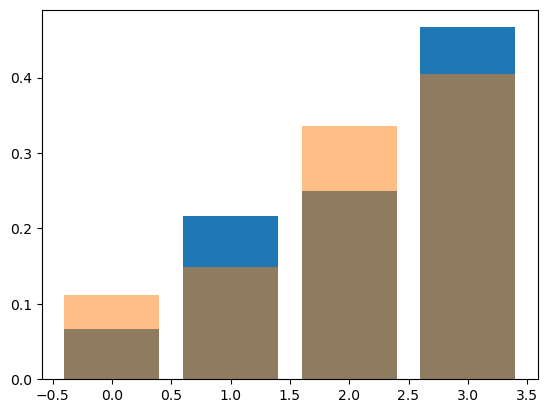

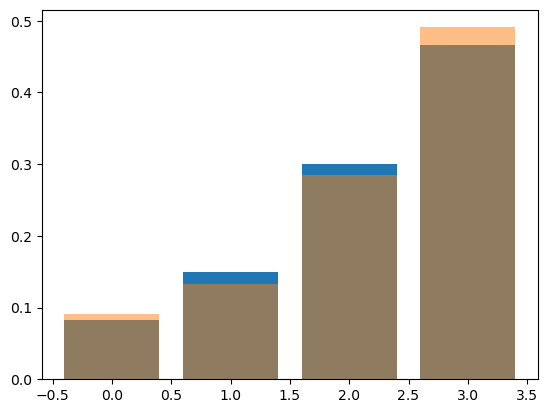

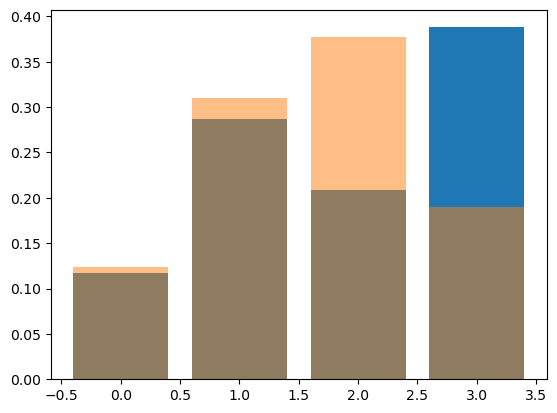

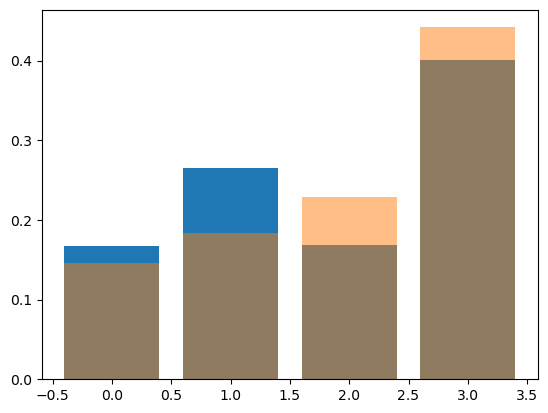

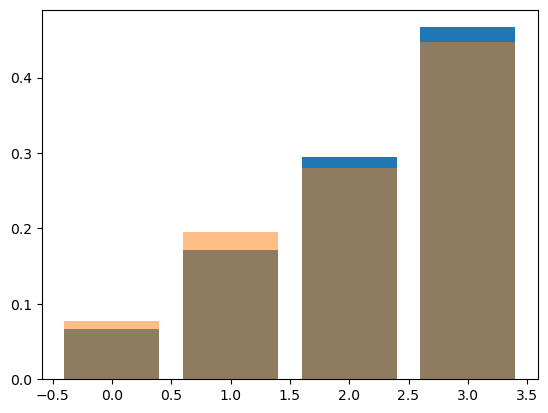

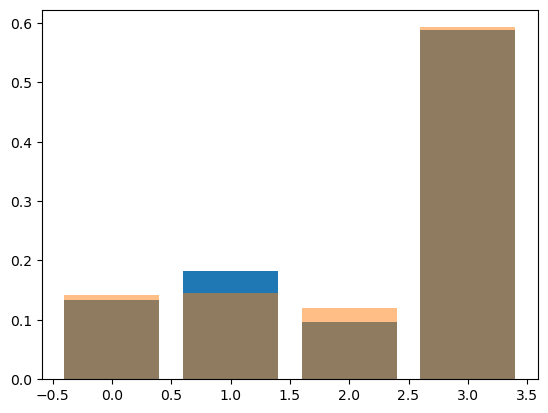

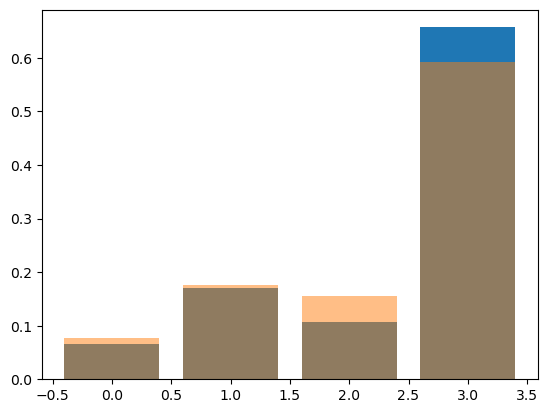

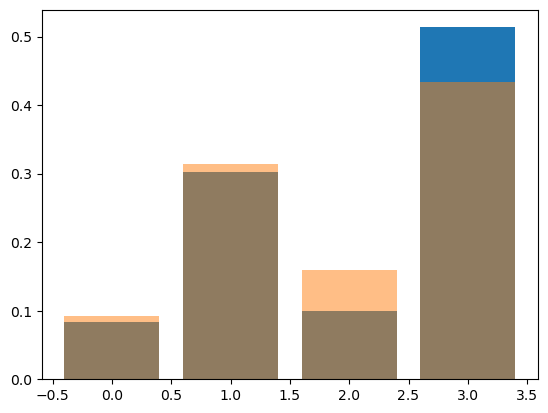

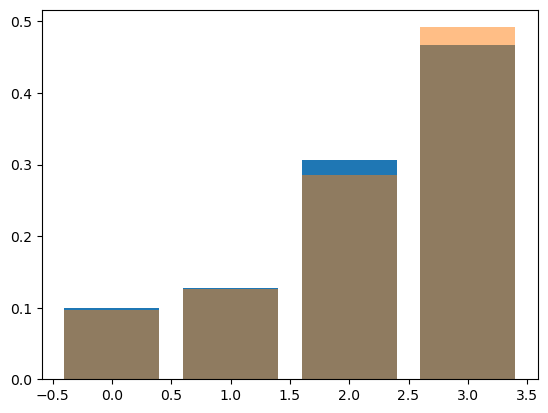

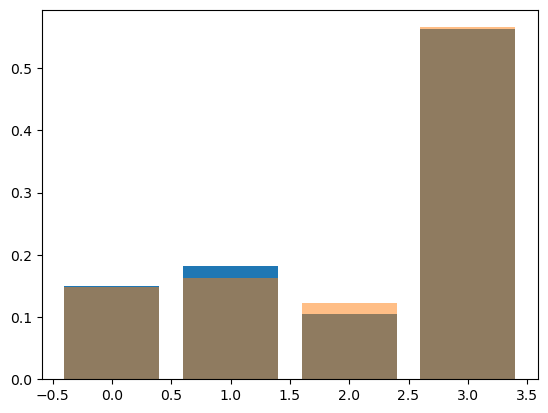

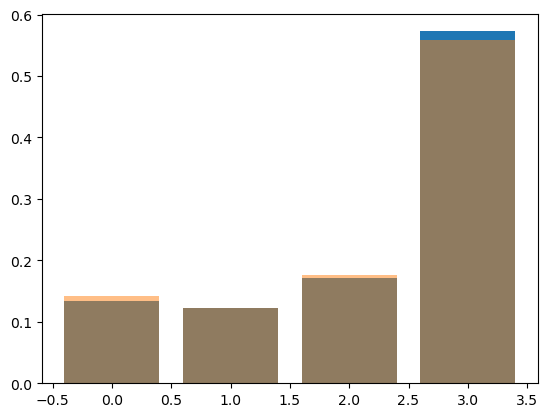

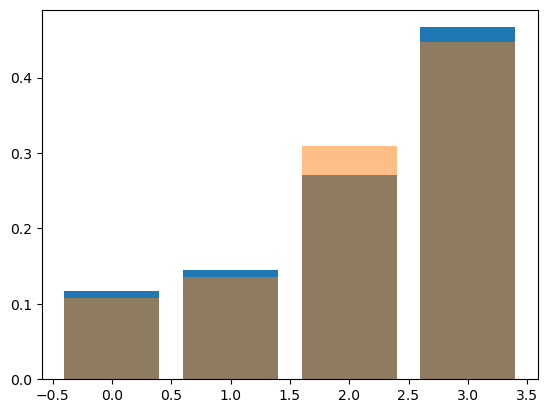

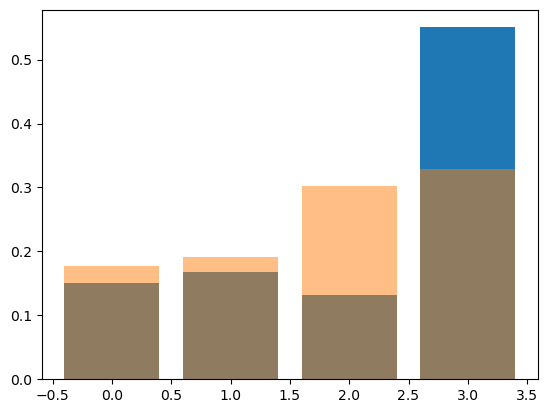

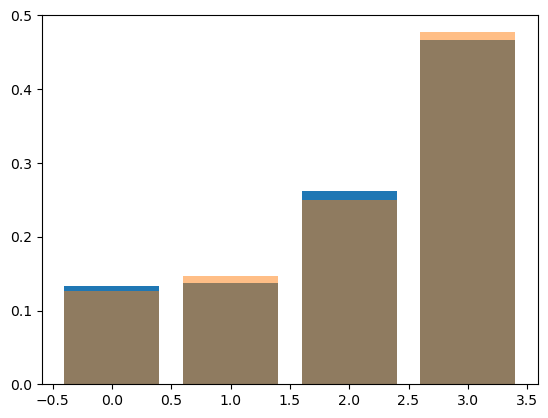

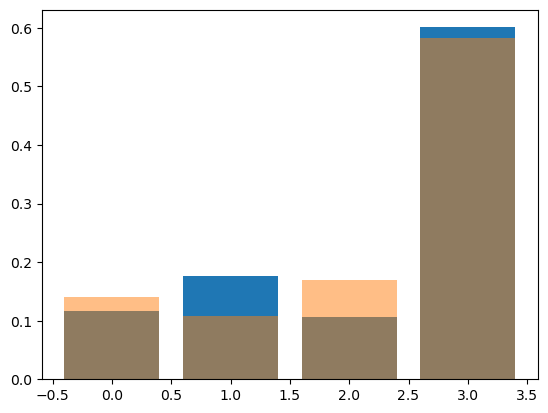

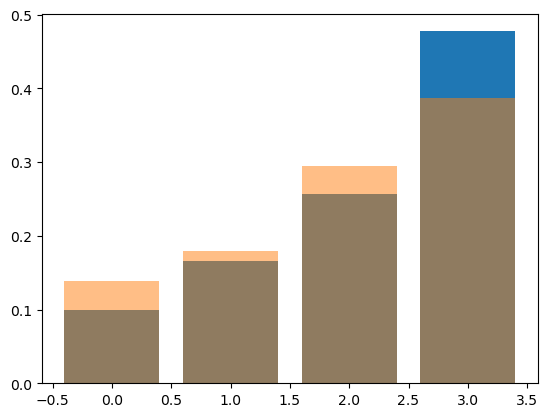

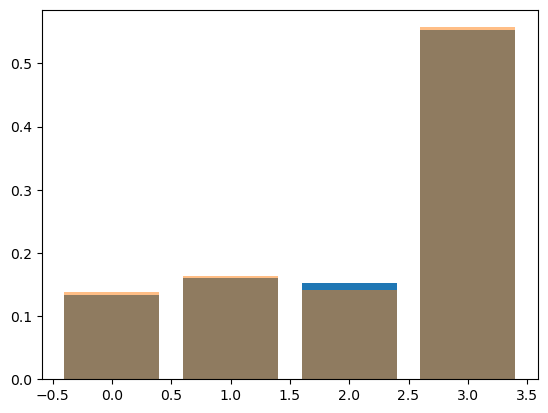

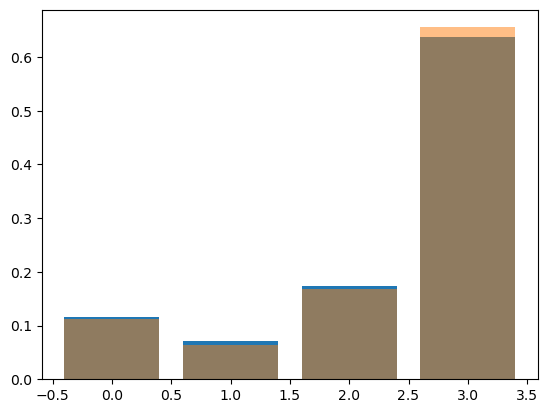

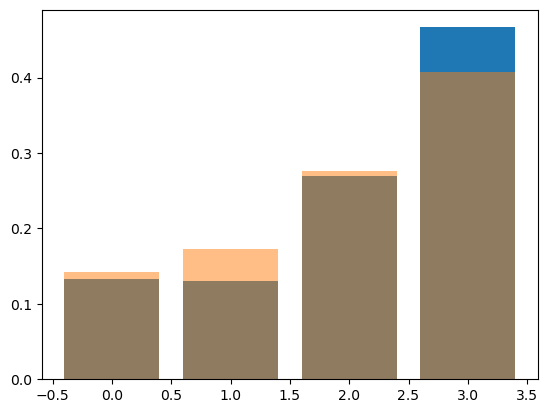

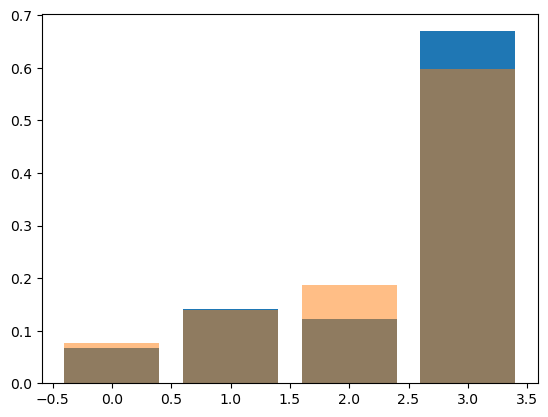

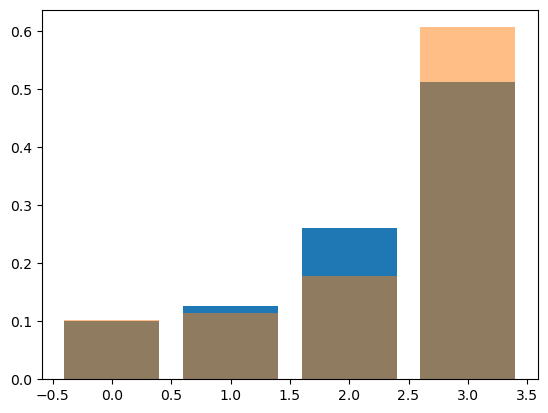

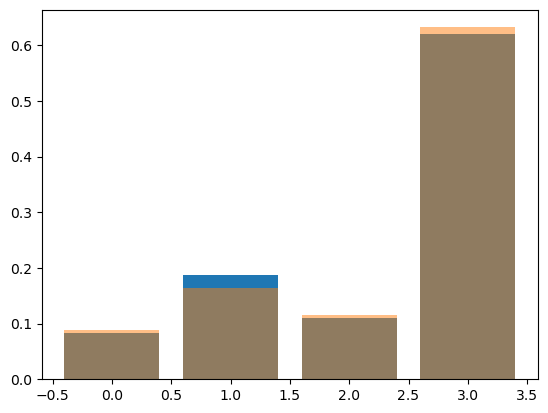

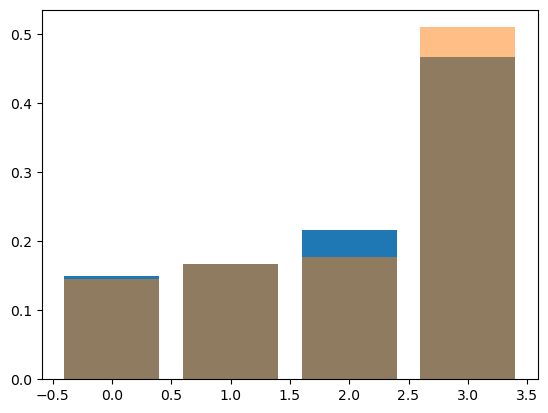

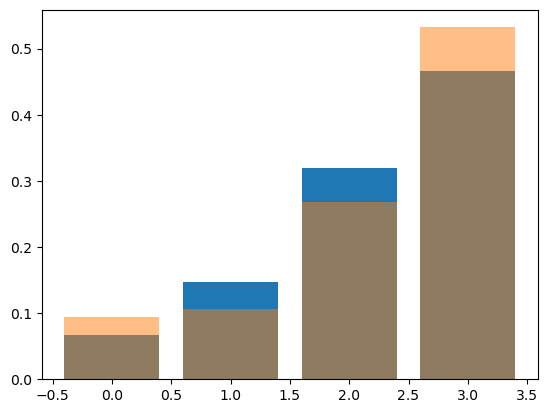

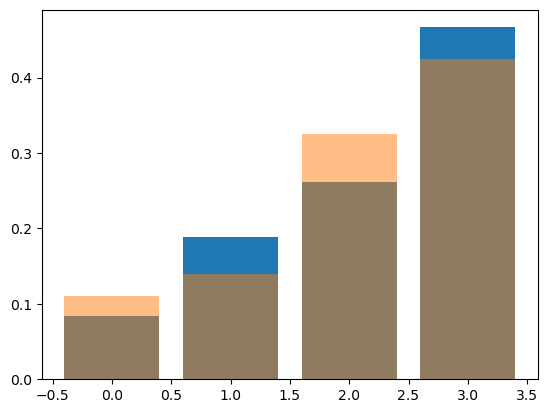

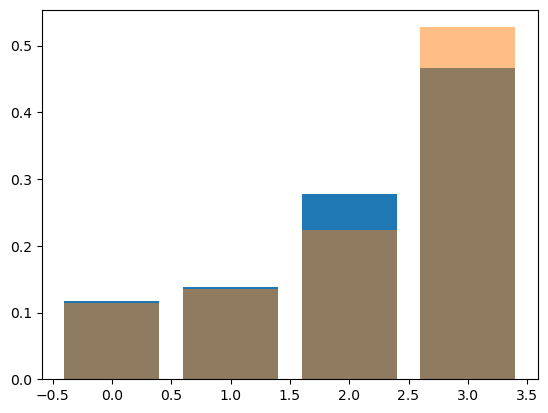

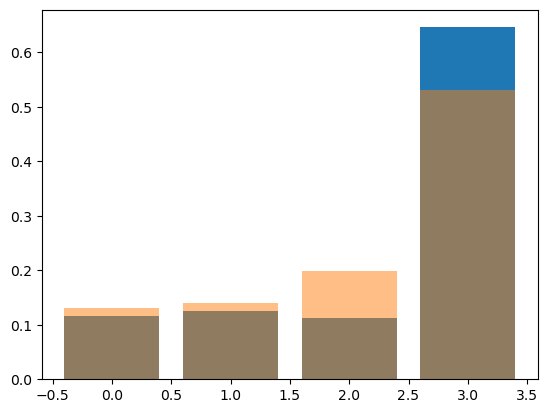

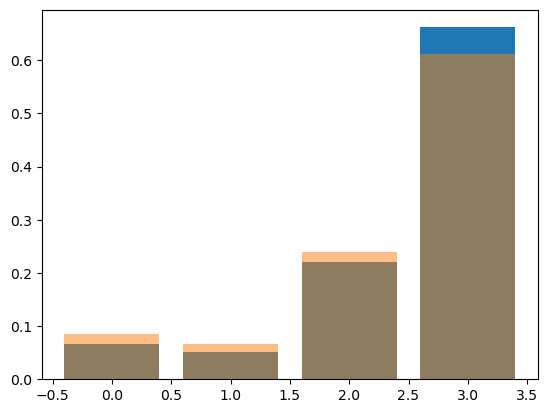

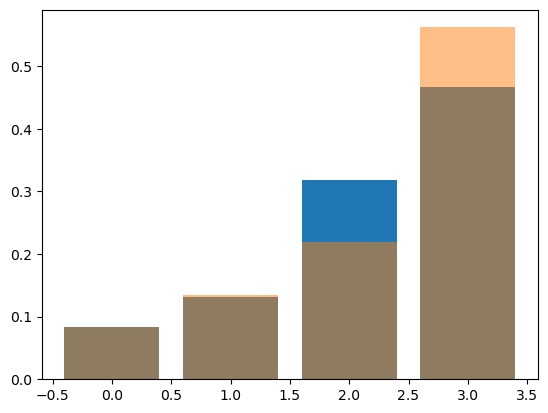

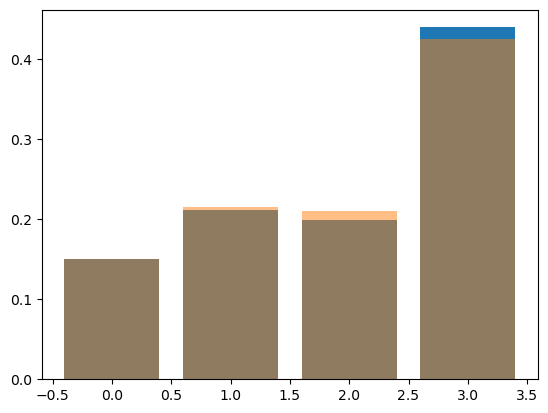

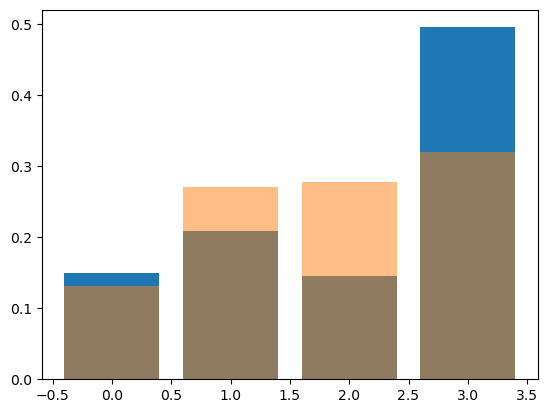

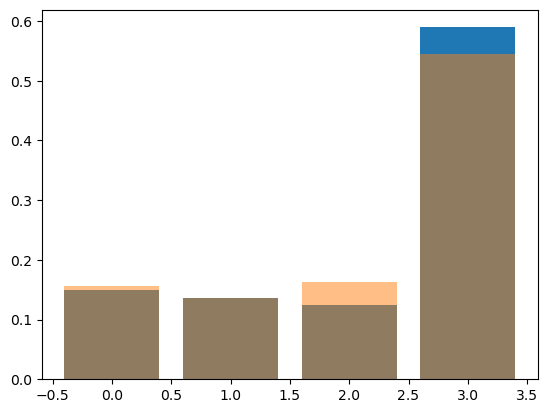

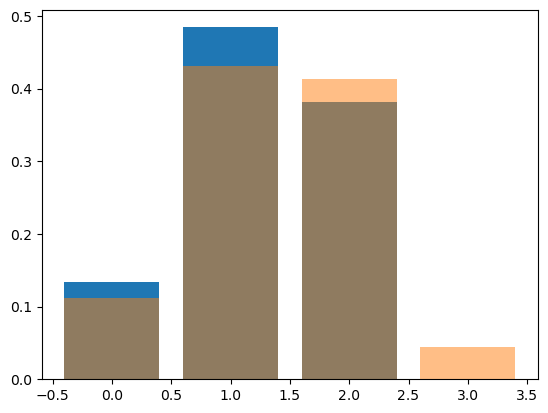

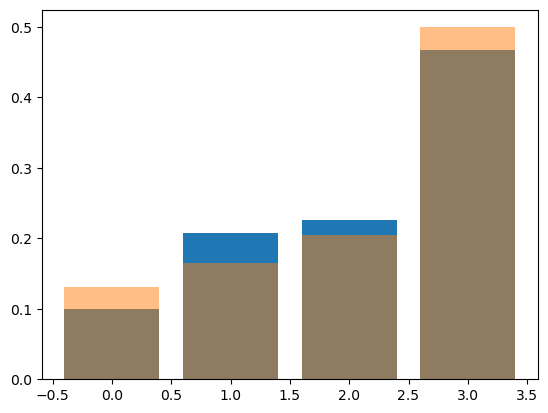

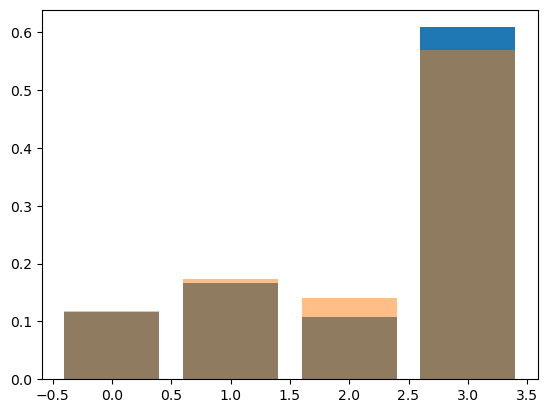

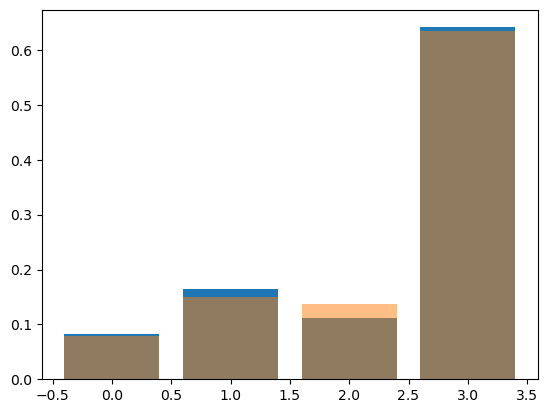

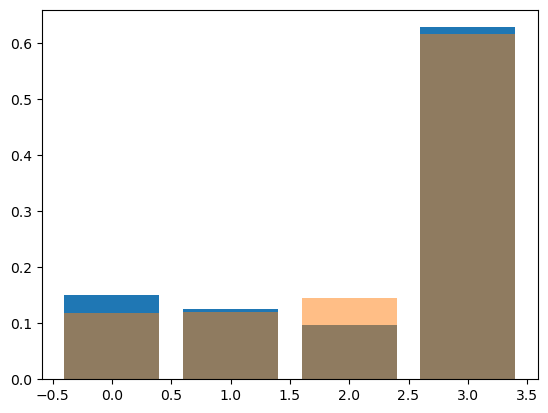

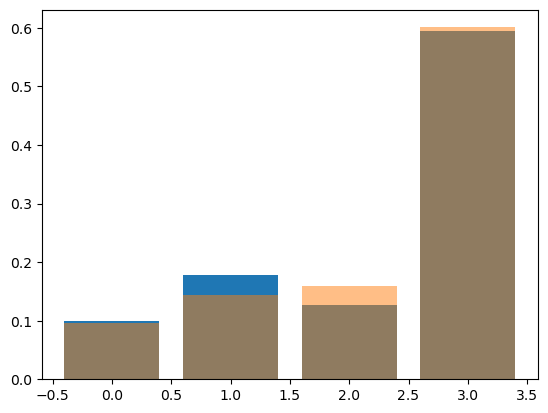

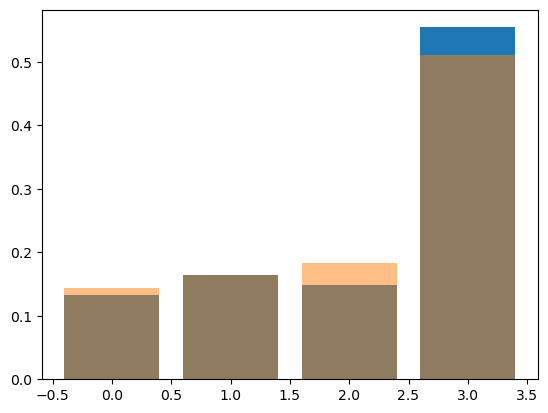

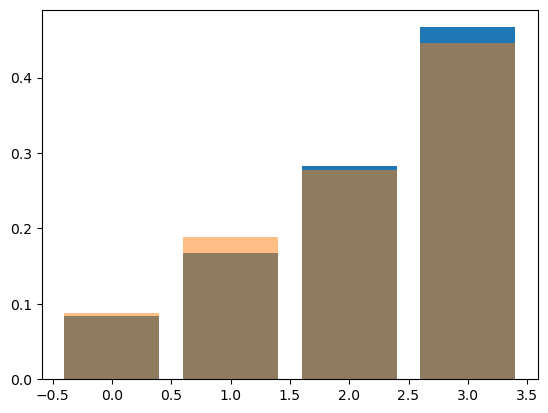

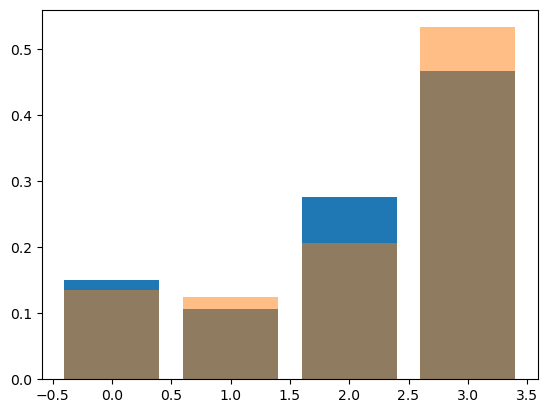

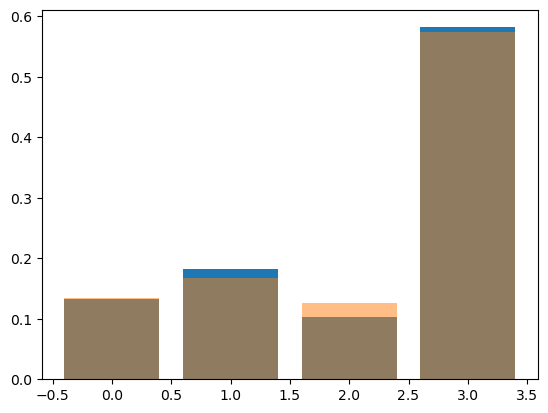

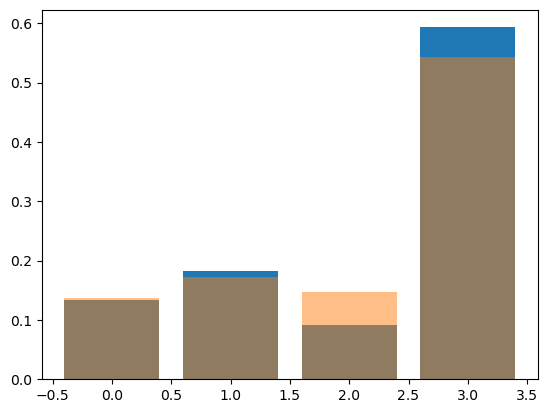

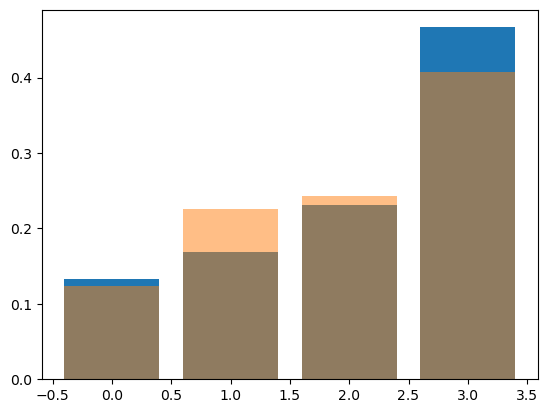

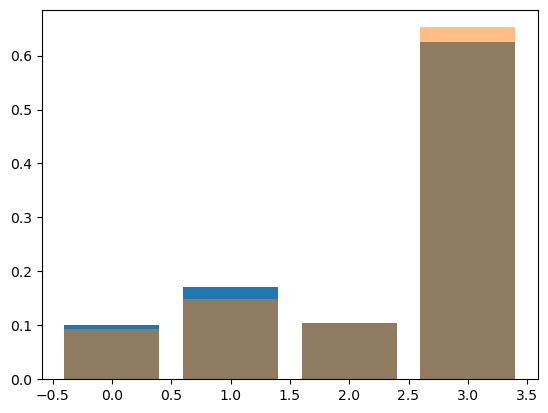

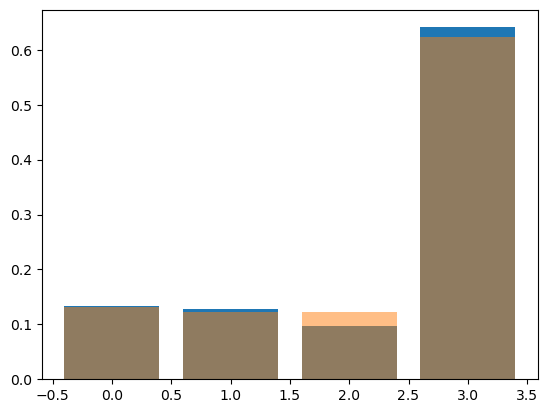

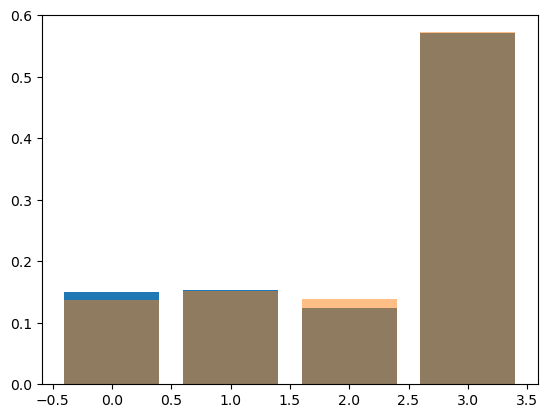

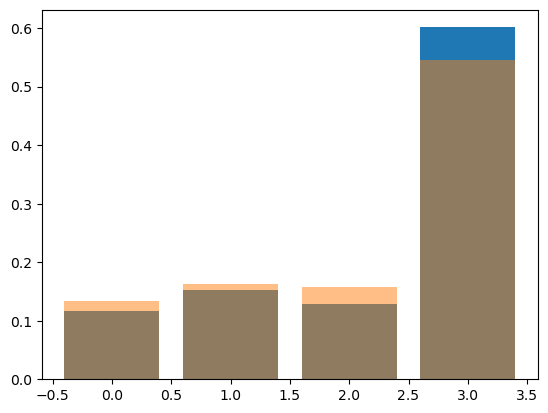

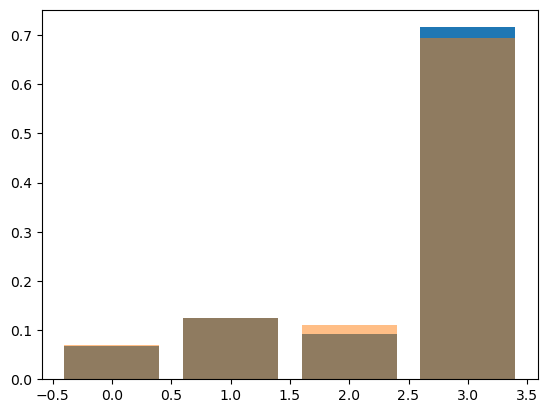

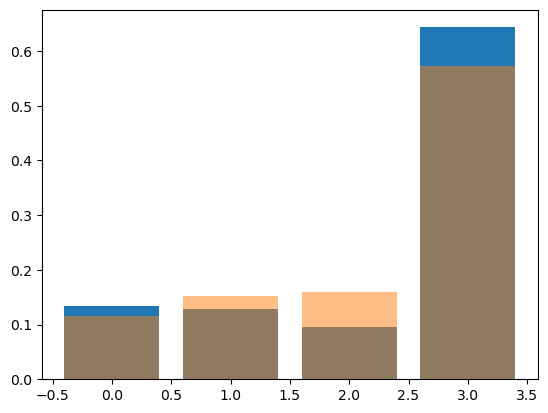

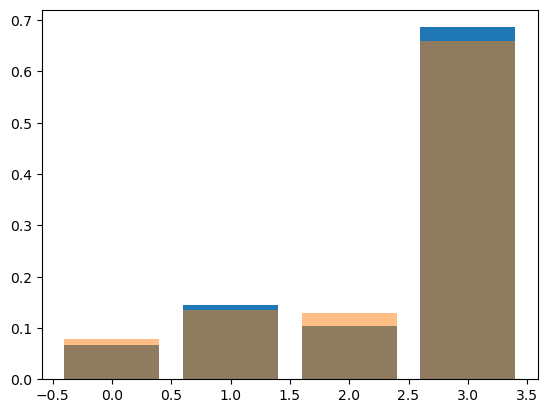

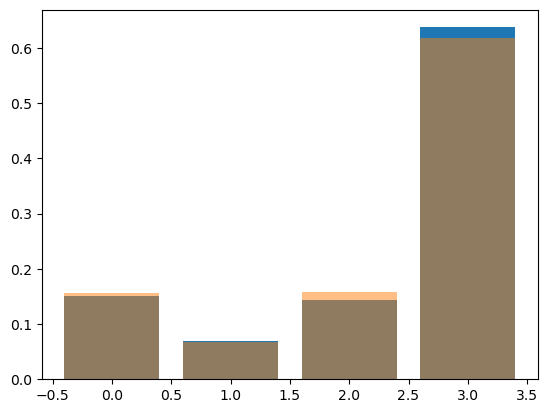

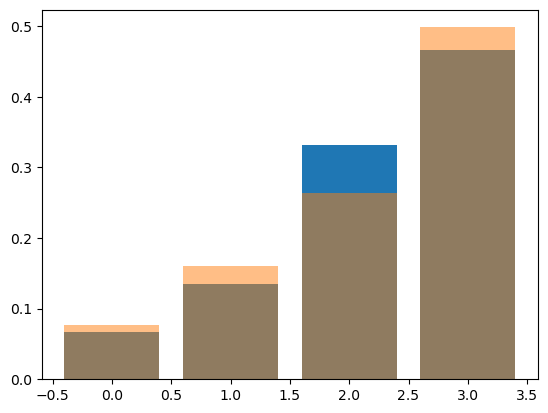

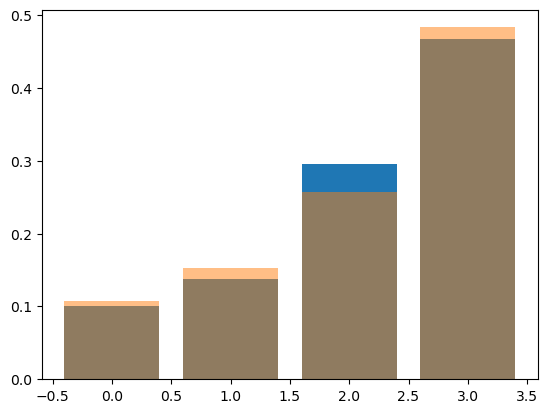

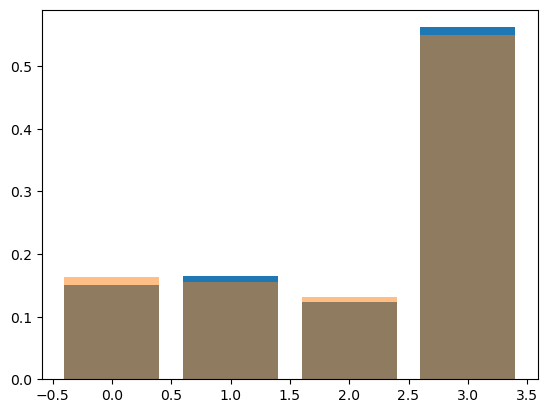

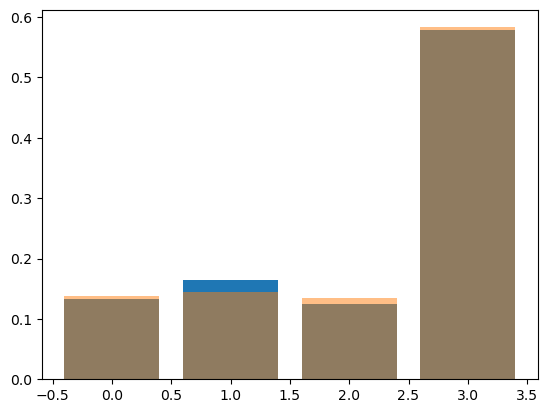

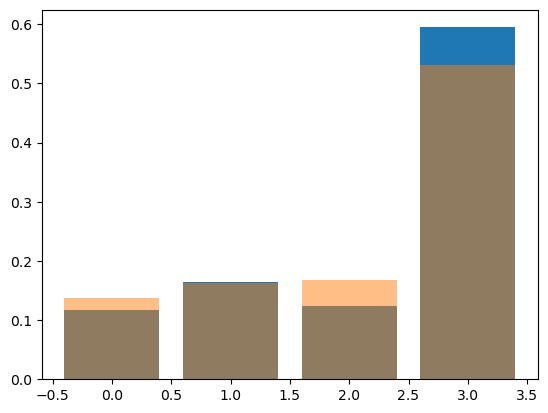

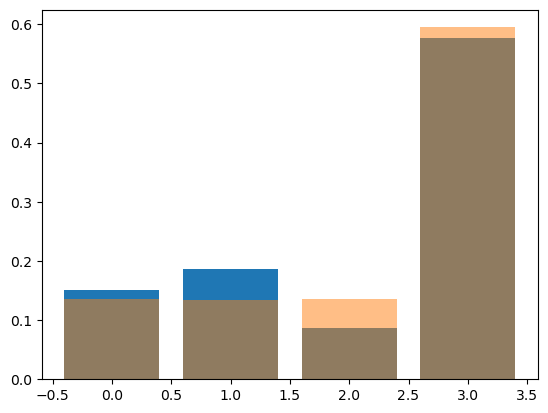

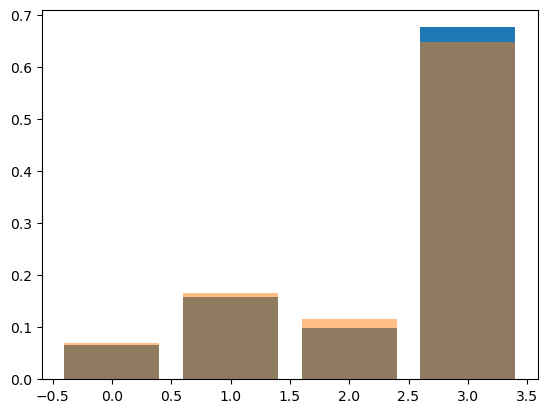

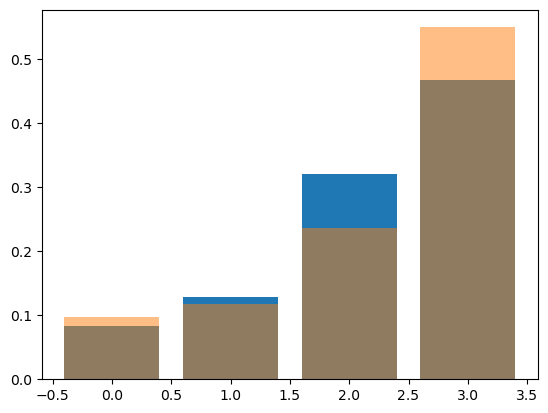

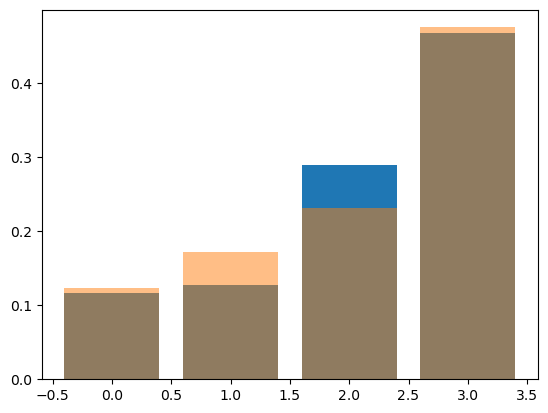

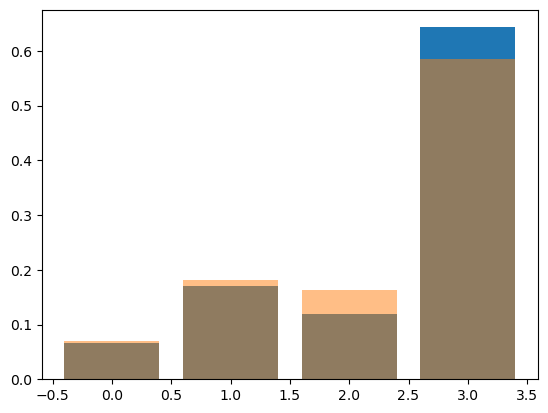

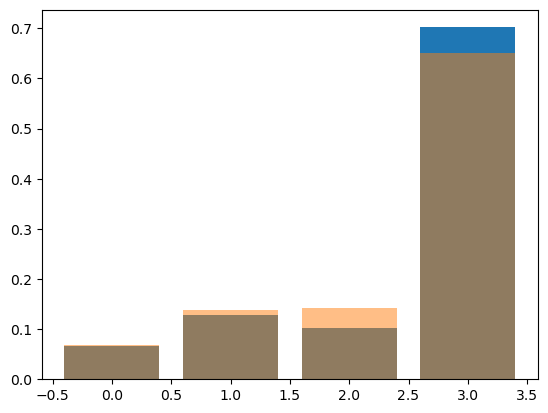

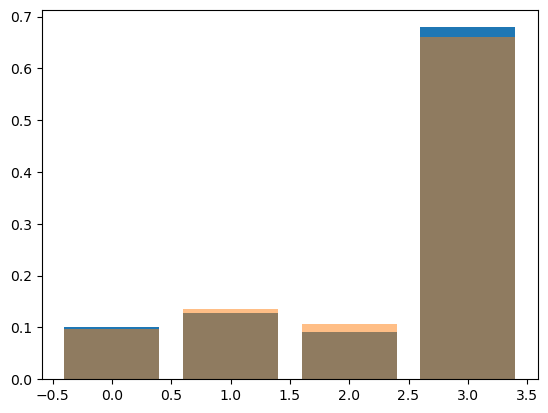

In [10]:
encoder.eval()
interval_model.eval()
downstream_val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=downstream_batch_size, shuffle=False, num_workers=0) # must be 0 for hdf5
for i, (traces, p_arrivals, s_arrivals, coda_ends, event_names) in enumerate(downstream_val_loader):
    downstream_optimizer.zero_grad()
    traces_mean = traces.mean(dim=2, keepdim=True)
    traces_std = traces.std(dim=2, keepdim=True) + 1e-9
    x = (traces - traces_mean) / traces_std  # normalize input traces
    x = x.to(device)
    num_timesteps = traces.size(-1)
    with torch.no_grad():
        x_patched, z_embeddings = encoder.forward(x, masked=False)
        alphas = interval_model(z_embeddings.transpose(1, 2))  # (B, T_out)
        dist = torch.distributions.Dirichlet(alphas + 1e-9)
        s1 = p_arrivals/num_timesteps
        s2 = s_arrivals/num_timesteps - s1
        s3 = coda_ends/num_timesteps - s1 - s2
        s4 = 1.0 - (s1 + s2 + s3)
        target = torch.stack([s1, s2, s3, s4], dim=-1)
        alphas = alphas.cpu()
        avg_pred = alphas/alphas.sum(dim=-1, keepdim=True)
        
    for (true_vals, pred_vals) in zip(target, avg_pred):
        plt.bar(np.arange(0, 4), true_vals)
        plt.bar(np.arange(0,4), pred_vals, alpha=0.5)
        plt.show()
    break